# PPG Feature Extraction and SpO2 Estimation

### Data Dictionary

* **`ecg`**: 3-lead ECG captured at 500Hz
* **`peaks`**: CSV ONLY, annotated in WFDB. The annotated ECG R peak (1 = peak, 0 = no peak)
* **`pleth_1`**: MAX30101 red wavelength PPG from the distal phalanx (first segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`pleth_2`**: MAX30101 infrared wavelength PPG from the distal phalanx (first segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`pleth_3`**: MAX30101 green wavelength PPG from the distal phalanx (first segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`pleth_4`**: MAX30101 red wavelength PPG from the proximal phalanx (base segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`pleth_5`**: MAX30101 infrared wavelength PPG from the proximal phalanx (base segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`pleth_6`**: MAX30101 green wavelength PPG from the proximal phalanx (base segment) of the left index finger palmar side (arbitrary units, 500Hz)
* **`lc_1`**: TAL221 load cell proximal phalanx (first segment) PPG sensor attachment pressure (arbitrary units, 80Hz)
* **`lc_2`**: TAL221 load cell (base segment) PPG sensor attachment pressure (arbitrary units, 80Hz)
* **`temp_1`**: distal phalanx (first segment) PPG sensor temperature (°C, 10Hz)
* **`temp_2`**: proximal phalanx (base segment) PPG sensor temperature in (°C, 10Hz)
* **`temp_3`**: InvenSenseMPU-9250 IMU temperature (°C, 500Hz)
* **`a_x`**: InvenSenseMPU-9250 IMU acceleration in x-direction (g, 500Hz)
* **`a_y`**: InvenSenseMPU-9250 IMU acceleration in y-direction (g, 500Hz)
* **`a_z`**: InvenSenseMPU-9250 IMU acceleration in z-direction (g, 500Hz)
* **`g_x`**: InvenSenseMPU-9250 IMU angular velocity around x-axis (°/s, 500Hz)
* **`g_y`**: InvenSenseMPU-9250 IMU angular velocity around y-axis (°/s, 500Hz)
* **`g_z`**: InvenSenseMPU-9250 IMU angular velocity around z-axis (°/s, 500Hz)
* Each CSV record includes a **`time`** column that was date shifted to de-indentify participants.

## 1. PPG Signal Processing and Identifying Beats

In [7]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from scipy.ndimage import gaussian_filter1d

In [8]:
# Loading and exploring the data

df = pd.read_csv("pulse-transit-time-ppg/csv/s1_run.csv")
df.head()

,time,ecg,peaks,pleth_1,pleth_2,pleth_3,pleth_4,pleth_5,pleth_6,lc_1,lc_2,temp_1,temp_2,temp_3,a_x,a_y,a_z,g_x,g_y,g_z
0,2021-01-01 18:33:22.232127,31978,0,83324,87262,6070,85787,99285,7017,5864032,5405674,28.5,30.13,30.264084,1.264203,0.071231,-10.321930,-0.508413,0.666570,-0.076496
1,2021-01-01 18:33:22.234127,32078,0,83324,87262,6070,85794,99281,7022,5864032,5405674,28.5,30.13,30.261089,1.104382,0.015563,-10.315345,-0.503886,0.708649,-0.057321
2,2021-01-01 18:33:22.236127,32148,0,83324,87277,6063,85782,99269,7015,5864032,5405674,28.5,30.13,30.264084,0.997834,0.074224,-10.381189,-0.494298,0.740873,-0.042407
3,2021-01-01 18:33:22.238127,32257,0,83319,87281,6070,85782,99269,7015,5857118,5405173,28.5,30.13,30.270075,0.921216,0.175983,-10.502102,-0.484178,0.758317,-0.034152
4,2021-01-01 18:33:22.240127,32380,0,83314,87258,6073,85787,99281,7015,5857118,5405173,28.5,30.13,30.264084,0.830232,0.268763,-10.652945,-0.475256,0.762046,-0.032687


In [16]:
df["peaks"].value_counts()

peaks
0    244615
1       659
Name: count, dtype: int64

**Q. Why consider only `pleth_1` and `pleth_2` for SpO2 estimation?**

SpO2 is estimated from a photoplethysmograph (PPG) signal by comparing the absorption of **red** and **infrared** light by the blood, as oxygenated and deoxygenated hemoglobin absorb these wavelengths differently. This comparison is used to calculate the ratio of AC (pulsatile) to DC (non-pulsatile) components of the PPG signal from both light wavelengths, which is then used in an empirical equation to determine the SpO2 level.

`pleth_1` & `pleth_2` (distal, fingertip):
* Usually stronger pulsatile signals (more blood perfusion at fingertip).
* Commonly used in commercial pulse oximeters.
* Better for clean SpO₂ estimation.

`pleth_4` & `pleth_5` (proximal, finger base):
* Signals can be weaker or noisier because perfusion is lower compared to fingertip.
* Still useful for redundancy, or if fingertip signals are noisy.
* Could be used to test robustness of the model across sensor placements.

In [21]:
df["pleth_1"].min(), df["pleth_1"].max()

(82057, 83391)

In [38]:
!python "src/load_data.py"

Found 67 recording CSVs. Example [WindowsPath('data/csv/s10_run.csv'), WindowsPath('data/csv/s10_sit.csv'), WindowsPath('data/csv/s10_walk.csv'), WindowsPath('data/csv/s11_run.csv'), WindowsPath('data/csv/s11_sit.csv')]


Metadata columns: ['record', 'activity', 'gender', 'height', 'weight', 'age', 'bp_sys_start', 'bp_sys_end', 'bp_dia_start', 'bp_dia_end', 'hr_1_start', 'hr_1_end', 'hr_2_start', 'hr_2_end', 'spo2_start', 'spo2_end']
Figure(1000x400)


In [36]:
%matplotlib inline

NameError: name 'recs' is not defined

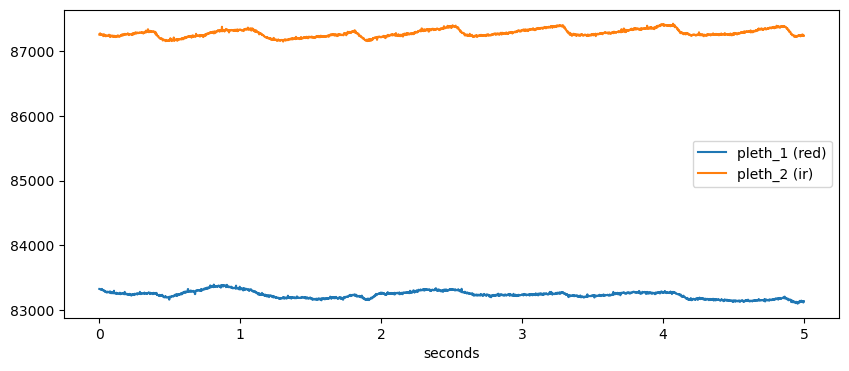

In [39]:

# quick plot first 5 seconds
plt.figure(figsize=(10,4))
t = (pd.to_datetime(df['time']) - pd.to_datetime(df['time']).iloc[0]).dt.total_seconds()
plt.plot(t.iloc[:2500], df['pleth_1'].iloc[:2500], label='pleth_1 (red)')
plt.plot(t.iloc[:2500], df['pleth_2'].iloc[:2500], label='pleth_2 (ir)')
plt.legend(); plt.xlabel('seconds'); plt.title(recs[0].name)
plt.show()